In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
import random
seed=1000
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
#read csv, print 5 rows
klangapi = pd.read_csv('klangapiCleanedDailyBaru.csv')

#change data type "date" from object to actual date for easy analysis
klangapi['date']=pd.to_datetime(klangapi['date'])
#set index to date
klangapi.set_index('date',inplace=True)

klangapi.head(10)

,wind_speed,wind_direction,temperature,relative_humidity,nox,no,so2,no2,o3,co,pm10
date,,,,,,,,,,,
2002-10-01,4.2125,170.1875,27.3729,72.7500,0.0751,0.0409,0.0097,0.0342,0.0241,2.3044,108.6875
2002-10-02,4.9542,111.8750,27.4375,72.8333,0.0601,0.0247,0.0077,0.0354,0.0203,1.7673,108.3333
2002-10-03,5.0542,123.2083,26.8250,77.0833,0.0610,0.0261,0.0119,0.0349,0.0191,1.7481,99.9583
2002-10-04,3.6958,134.3750,26.4875,79.2500,0.0871,0.0506,0.0121,0.0366,0.0191,2.4892,116.6250
2002-10-05,4.4708,188.9167,26.4750,80.3333,0.0539,0.0305,0.0072,0.0234,0.0165,1.7731,94.9583
2002-10-06,4.3167,142.6667,26.0750,82.4167,0.0471,0.0229,0.0074,0.0242,0.0202,1.5633,83.7083
2002-10-07,3.9583,177.5000,25.4000,84.0625,0.0737,0.0487,0.0089,0.0250,0.0120,1.9575,75.5625
2002-10-08,5.4917,137.3750,27.5083,76.7500,0.0258,0.0105,0.0071,0.0154,0.0188,0.9352,53.6458
2002-10-09,5.1500,164.2083,27.8250,74.8333,0.0326,0.0149,0.0090,0.0177,0.0311,1.0512,70.3958


In [196]:
trainTest=klangapi.loc['2002-10-01':'2019-12-31'].copy() #2002-2017/3/31
verifyDeploy=klangapi.loc['2020-01-01':'2020-12-31'].copy() #2018
jumlahTrainNTest=trainTest.shape[0]
jumlahVerification=verifyDeploy.shape[0]
print(jumlahTrainNTest,jumlahVerification,jumlahTrainNTest+jumlahVerification)

6039 366 6405


In [197]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# scaler = StandardScaler()
# scaler = scaler.fit(klangapi)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(klangapi)
trainTestScaled = scaler.transform(trainTest)
verifyDeployScaled = scaler.transform(verifyDeploy)
trainTestScaled.shape,verifyDeployScaled.shape

((6039, 11), (366, 11))

## THIS SEGMENT IS TO CHECK THE DATA

In [198]:
trainTest.iloc[[-1]]

,wind_speed,wind_direction,temperature,relative_humidity,nox,no,so2,no2,o3,co,pm10
date,,,,,,,,,,,
2019-12-31,0.9178,117.25,27.3971,84.5361,0.0358,0.0157,0.0007,0.0202,0.0154,1.3941,52.8893


In [199]:
scaler.inverse_transform(trainTestScaled[[-1]])[0][10]


52.8893

In [200]:
verifyDeploy.iloc[[0]]

,wind_speed,wind_direction,temperature,relative_humidity,nox,no,so2,no2,o3,co,pm10
date,,,,,,,,,,,
2020-01-01,1.1107,164.5,28.3942,75.1008,0.0348,0.0204,0.0008,0.0143,0.015,1.4294,46.0017


In [201]:
scaler.inverse_transform(verifyDeployScaled[[0]])[0][10]

46.0017

In [202]:
##splitting dataset into train and test split
training_size=int(len(trainTestScaled)*0.80)
test_size=len(trainTestScaled)-training_size
train,test=trainTestScaled[0:training_size,:],trainTestScaled[training_size:len(trainTestScaled),:]
train.shape,test.shape

((4831, 11), (1208, 11))

## END OF SEGMENT

In [66]:
# references target features
# 10 = pm10
# 9 = co
# 8 = o3
# 7 = no2
# 6 = so2
# 5 = no
# 4 = nox

In [708]:
# function to organize data in correct forms so that the data can be fitted to the model
# data, number of past days, number of features, target pollutants to be predicted
def to_sequences(dataset, n_past, no_features, target_features):
    # n_past: Number of past days we want to use to predict the future.
    X = []
    y = []
    n_future = 1   # Number of days we want to look into the future based on the past days.
    for i in range(n_past, len(dataset) - n_future +1):
        X.append(dataset[i - n_past:i, 0:no_features])
        y.append(dataset[i + n_future - 1:i + n_future, target_features]) 
    return np.array(X), np.array(y)

# function to build LSTM model
def modelling(no_past, no_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32))
    # model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse')
    return model
    #model.summary()#ANN->RNN->LSTM
    
# function to retrieve performance of the model
def performance_measure(actual,pred) :
    rmse=math.sqrt(mean_squared_error(actual,pred, squared=False))
    mae=mean_absolute_error(actual, pred)
    mape=mean_absolute_percentage_error(actual, pred)*100
    return rmse,mae,mape


# PM10 Modelling : 10

### Restrustured the data and determine the target features

In [709]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1],10)
testX, testY = to_sequences(test, 3, klangapi.shape[1],10)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (4828, 3, 11).
trainY shape == (4828, 1).
testX shape == (1205, 3, 11).
testY shape == (1205, 1).


In [710]:
trainY[0][0] == trainTestScaled[3][10]

True

### Training model

In [711]:
#trainX(number of rows, number of past days, number of features)
#PM10 Modelling
modelPM10=modelling(trainX.shape[1],trainX.shape[2]) 
modelPM10.summary()
history = modelPM10.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 3, 128)            71680     
_________________________________________________________________
lstm_82 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
604/604 [==============================] - 2s 3ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 2/20
60

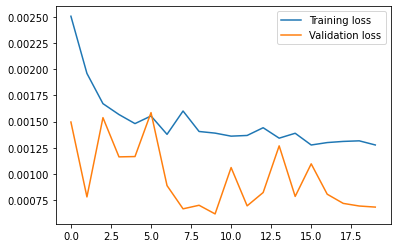

In [712]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [713]:
prediction = modelPM10.predict(trainX)


In [714]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,10]


In [715]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,10]
#klangapi.iloc[3:4831,10]

In [716]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 4.462703836547335.
MAE : 13.042557235167218.
MAPE : 19.985777652448625.


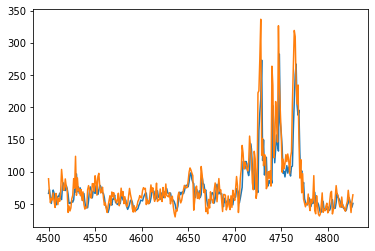

In [717]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

In [718]:
train_results

,Train Predictions,Actuals
0,85.137184,116.6250
1,93.526672,94.9583
2,80.930786,83.7083
3,76.369171,75.5625
4,72.115456,53.6458
...,...,...
4823,59.529263,57.9583
4824,53.534363,50.3750
4825,51.497665,36.6667
4826,45.060429,54.3333


### Deploy on unseen data 2020


In [719]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1],10)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [720]:
prediction = modelPM10.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,10]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,10]

In [721]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 3.4451246956089316.
MAE : 10.083892372555903.
MAPE : 36.18160805879481.


In [722]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,41.336864,33.9980
1,40.072018,33.8509
2,42.622562,31.7105
3,42.804283,34.8861
4,43.230789,35.9569
...,...,...
358,39.825111,19.1635
359,37.042465,34.3774
360,38.677299,23.4586
361,36.670479,26.0311


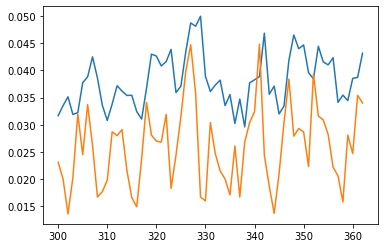

In [842]:
plt.plot(test_results['Train Predictions'][300:])
plt.plot(test_results['Actuals'][300:])

# CO Modelling : 9

In [724]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 9)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 9)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (4828, 3, 11).
trainY shape == (4828, 1).
testX shape == (1205, 3, 11).
testY shape == (1205, 1).


In [725]:
trainY[0][0] == trainTestScaled[3][9]

True

In [726]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 3, 128)            71680     
_________________________________________________________________
lstm_84 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_59 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [727]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
604/604 [==============================] - 2s 3ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 2/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 3/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 4/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 5/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 6/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 7/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 8/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 9/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 10/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0013

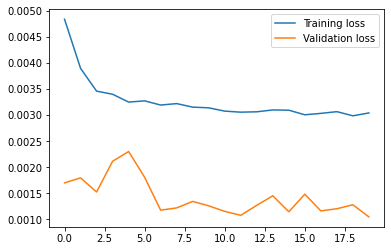

In [728]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [729]:
prediction = model.predict(trainX)

In [730]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,9]
y_pred_future.shape

(4828,)

In [731]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,9]
actualY.shape

(4828,)

In [732]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.5728850638573436.
MAE : 0.2386666175268658.
MAPE : 24.52295567081408.


In [733]:
train_results

,Train Predictions,Actuals
0,85.137184,116.6250
1,93.526672,94.9583
2,80.930786,83.7083
3,76.369171,75.5625
4,72.115456,53.6458
...,...,...
4823,59.529263,57.9583
4824,53.534363,50.3750
4825,51.497665,36.6667
4826,45.060429,54.3333


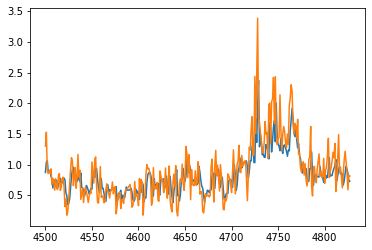

In [734]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

### Deploy on unseen data


In [735]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 9)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [736]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,9]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,9]

In [737]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.4153860533995155.
MAE : 0.1401204996487326.
MAPE : 20.40977746410188.


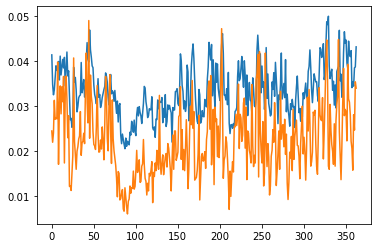

In [845]:
plt.plot(test_results['Train Predictions'][:])
plt.plot(test_results['Actuals'][:])

In [739]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,1.005126,0.8596
1,0.913491,0.9872
2,0.974038,0.8925
3,0.957718,0.8877
4,0.940530,0.8069
...,...,...
358,0.892216,0.6674
359,0.865657,0.8996
360,0.924372,0.8214
361,0.921358,1.0505


# O3 Modelling : 8

In [847]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 8)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 8)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (4828, 3, 11).
trainY shape == (4828, 1).
testX shape == (1205, 3, 11).
testY shape == (1205, 1).


In [848]:
trainY[0][0] == trainTestScaled[3][8]

True

In [849]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (None, 3, 128)            71680     
_________________________________________________________________
lstm_102 (LSTM)              (None, 64)                49408     
_________________________________________________________________
dense_77 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [850]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
604/604 [==============================] - 2s 3ms/step - loss: 0.0145 - val_loss: 0.0109
Epoch 2/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 3/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 4/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0101
Epoch 5/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 6/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0096
Epoch 7/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0096
Epoch 8/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0089
Epoch 9/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 10/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 0.0096

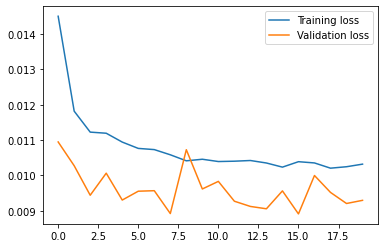

In [851]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [852]:
prediction = model.predict(trainX)

In [853]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,8]
y_pred_future.shape

(4828,)

In [854]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,8]
actualY.shape

(4828,)

In [855]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.07136396724273661.
MAE : 0.0039124227176467455.
MAPE : 26.692523041350334.


In [856]:
train_results

,Train Predictions,Actuals
0,0.054375,0.0871
1,0.060227,0.0539
2,0.040846,0.0471
3,0.051442,0.0737
4,0.056502,0.0258
...,...,...
4823,0.040809,0.0450
4824,0.042433,0.0295
4825,0.033219,0.0235
4826,0.033165,0.0357


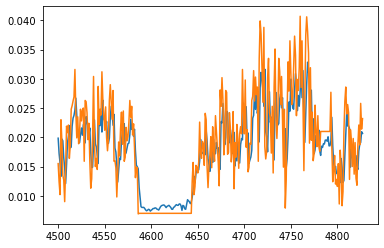

In [857]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

### Deploy on unseen data


In [858]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 8)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [859]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,8]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,8]

In [860]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.06547957562837321.
MAE : 0.0031976811603409527.
MAPE : 24.28312981527851.


In [861]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.013288,0.0149
1,0.014295,0.0119
2,0.014029,0.0100
3,0.013621,0.0101
4,0.013028,0.0129
...,...,...
358,0.016216,0.0223
359,0.018010,0.0159
360,0.016553,0.0133
361,0.015521,0.0135


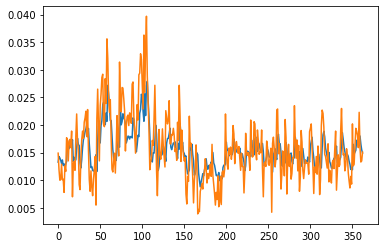

In [862]:
plt.plot(test_results['Train Predictions'][:])
plt.plot(test_results['Actuals'][:])

# NO2 Modelling : 7

In [756]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 7)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 7)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (4828, 3, 11).
trainY shape == (4828, 1).
testX shape == (1205, 3, 11).
testY shape == (1205, 1).


In [757]:
trainY[0][0] == trainTestScaled[3][7]

True

In [758]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX,testY), verbose=1)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 3, 128)            71680     
_________________________________________________________________
lstm_88 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_63 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_34 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
151/151 [==============================] - 1s 6ms/step - loss: 0.0239 - val_loss: 0.0117
Epoch 2/20
15

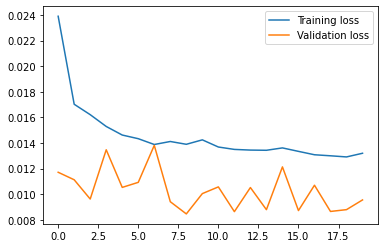

In [759]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [760]:
prediction = model.predict(trainX)

In [761]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,7]
y_pred_future.shape

(4828,)

In [762]:
# y_pred_future=np.round_(y_pred_future, decimals = 4)

In [763]:
y_pred_future

array([0.02850311, 0.02814826, 0.02244609, ..., 0.02184581, 0.02025628,
       0.02259924], dtype=float32)

In [764]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,7]
actualY.shape

(4828,)

In [765]:
actualY

array([0.0366, 0.0234, 0.0242, ..., 0.0158, 0.0236, 0.0219])

In [766]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.0711543648135766.
MAE : 0.003979475220090261.
MAPE : 340193455806.5191.


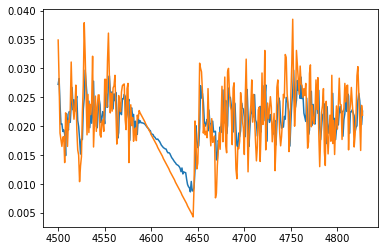

In [767]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

In [768]:
train_results

,Train Predictions,Actuals
0,0.028503,0.0366
1,0.028148,0.0234
2,0.022446,0.0242
3,0.024106,0.0250
4,0.021946,0.0154
...,...,...
4823,0.025673,0.0257
4824,0.024409,0.0209
4825,0.021846,0.0158
4826,0.020256,0.0236


In [769]:
# klangapi.loc['2015-04-24':'2015-06-30']['no2'].plot()

### Deploy on unseen data


In [770]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 8)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [771]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,7]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,7]

In [772]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.08975722351444286.
MAE : 0.006901535320713947.
MAPE : 71.3500944181001.


In [773]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.021059,0.012806
1,0.019956,0.010138
2,0.018430,0.008449
3,0.019818,0.008537
4,0.020209,0.011028
...,...,...
358,0.019943,0.019387
359,0.019295,0.013696
360,0.021332,0.011383
361,0.020905,0.011561


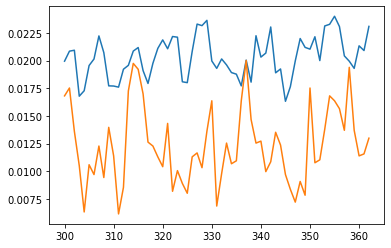

In [774]:
plt.plot(test_results['Train Predictions'][300:])
plt.plot(test_results['Actuals'][300:])

# SO2 Modelling : 6

In [775]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 6)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 6)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (4828, 3, 11).
trainY shape == (4828, 1).
testX shape == (1205, 3, 11).
testY shape == (1205, 1).


In [776]:
trainY[0][0] == trainTestScaled[3][6]

True

In [777]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 3, 128)            71680     
_________________________________________________________________
lstm_90 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [778]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
604/604 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 2/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 3/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 4/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 5/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 6/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 7/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 8/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 9/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 10/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0058

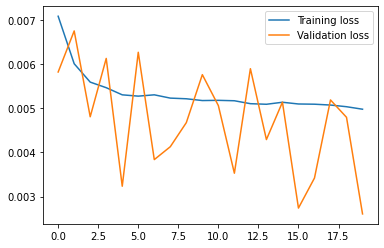

In [779]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [780]:
prediction = model.predict(trainX)

In [781]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,6]
y_pred_future.shape

(4828,)

In [782]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,6]
actualY.shape

(4828,)

In [783]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.04388042972653474.
MAE : 0.0013496251072260832.
MAPE : 805031703235.7991.


In [784]:
train_results

,Train Predictions,Actuals
0,0.028503,0.0366
1,0.028148,0.0234
2,0.022446,0.0242
3,0.024106,0.0250
4,0.021946,0.0154
...,...,...
4823,0.025673,0.0257
4824,0.024409,0.0209
4825,0.021846,0.0158
4826,0.020256,0.0236


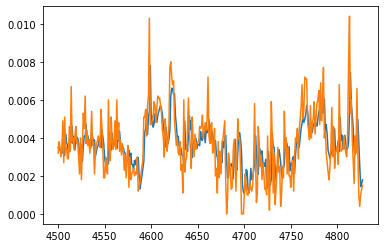

In [785]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

### Deploy on unseen data


In [786]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 6)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [787]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,6]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,6]

In [788]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.03764064938186056.
MAE : 0.0013083296480273043.
MAPE : 127.64058645364882.


In [789]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.001813,0.0006
1,0.001985,0.0009
2,0.002067,0.0011
3,0.002168,0.0011
4,0.002102,0.0005
...,...,...
358,0.002346,0.0009
359,0.002482,0.0012
360,0.002828,0.0011
361,0.002665,0.0014


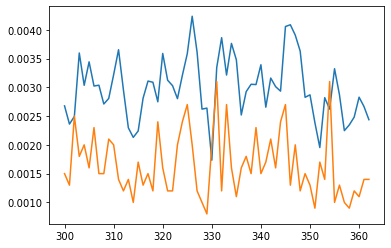

In [790]:
plt.plot(test_results['Train Predictions'][300:])
plt.plot(test_results['Actuals'][300:])

# NO Modelling : 5

In [836]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 5)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 5)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (4828, 3, 11).
trainY shape == (4828, 1).
testX shape == (1205, 3, 11).
testY shape == (1205, 1).


In [837]:
trainY[0][0] == trainTestScaled[3][5]

True

In [838]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 3, 128)            71680     
_________________________________________________________________
lstm_100 (LSTM)              (None, 64)                49408     
_________________________________________________________________
dense_75 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [839]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
604/604 [==============================] - 2s 3ms/step - loss: 0.0126 - val_loss: 0.0085
Epoch 2/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 3/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0080
Epoch 4/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0160
Epoch 5/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0080
Epoch 6/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0121
Epoch 7/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0071
Epoch 8/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 9/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0139
Epoch 10/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0091

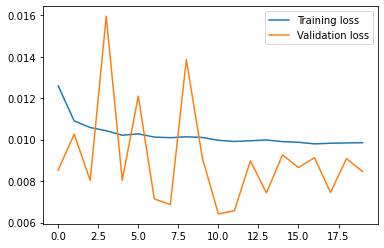

In [840]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
prediction = model.predict(trainX)

In [ ]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
y_pred_future.shape

In [798]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,5]
actualY.shape

(4828,)

In [799]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.09097798382107446.
MAE : 0.00628572499964018.
MAPE : 56.880078122120594.


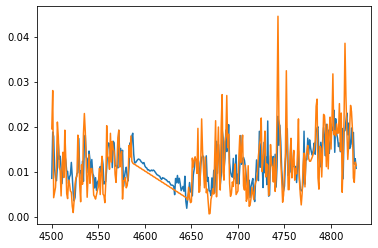

In [800]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

In [801]:
train_results

,Train Predictions,Actuals
0,0.025289,0.0506
1,0.032138,0.0305
2,0.020828,0.0229
3,0.026772,0.0487
4,0.034085,0.0105
...,...,...
4823,0.016028,0.0194
4824,0.018700,0.0086
4825,0.011653,0.0076
4826,0.012864,0.0121


### Deploy on unseen data


In [802]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 5)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [803]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,6]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,5]

In [804]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.06741604795161105.
MAE : 0.0031600718736114904.
MAPE : 42.984016082299746.


In [805]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.006444,0.0081
1,0.005068,0.0073
2,0.004780,0.0058
3,0.004769,0.0122
4,0.005466,0.0063
...,...,...
358,0.004924,0.0027
359,0.004955,0.0082
360,0.005610,0.0063
361,0.005752,0.0121


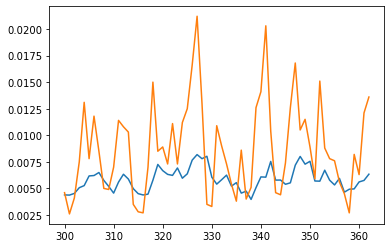

In [806]:
plt.plot(test_results['Train Predictions'][300:])
plt.plot(test_results['Actuals'][300:])

# NOX Modelling : 4

In [807]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 4)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 4)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (4828, 3, 11).
trainY shape == (4828, 1).
testX shape == (1205, 3, 11).
testY shape == (1205, 1).


In [808]:
trainY[0][0] == trainTestScaled[3][4]

True

In [809]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 3, 128)            71680     
_________________________________________________________________
lstm_94 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_69 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [810]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
604/604 [==============================] - 2s 3ms/step - loss: 0.0132 - val_loss: 0.0074
Epoch 2/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 3/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0066
Epoch 4/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0166
Epoch 5/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 6/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0124
Epoch 7/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 8/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0069
Epoch 9/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0131
Epoch 10/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0102

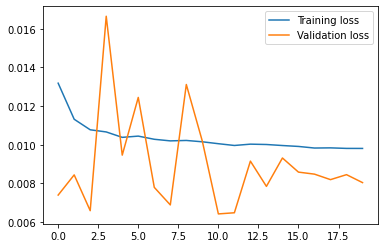

In [811]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [812]:
prediction = model.predict(trainX)

In [813]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
y_pred_future.shape

(4828,)

In [814]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,4]
actualY.shape

(4828,)

In [815]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.10875208988576765.
MAE : 0.009238024539310198.
MAPE : 27.41612345088797.


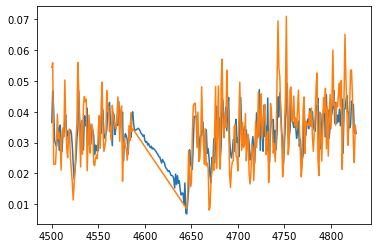

In [816]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

In [817]:
train_results

,Train Predictions,Actuals
0,0.054375,0.0871
1,0.060227,0.0539
2,0.040846,0.0471
3,0.051442,0.0737
4,0.056502,0.0258
...,...,...
4823,0.040809,0.0450
4824,0.042433,0.0295
4825,0.033219,0.0235
4826,0.033165,0.0357


### Deploy on unseen data


In [818]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 4)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [819]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,4]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,4]

In [820]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.11382817664430794.
MAE : 0.011521334007751842.
MAPE : 66.49709193013847.


In [821]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.041384,0.0245
1,0.034832,0.0220
2,0.032534,0.0241
3,0.033611,0.0313
4,0.036143,0.0271
...,...,...
358,0.035448,0.0158
359,0.034447,0.0281
360,0.038519,0.0247
361,0.038709,0.0354


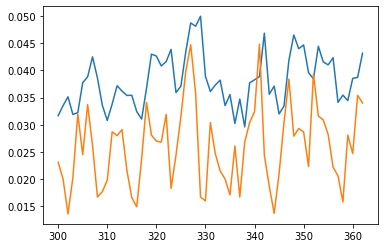

In [822]:
plt.plot(test_results['Train Predictions'][300:])
plt.plot(test_results['Actuals'][300:])

In [ ]:
#no2 so2
#train data mape 20-30
#data 2020 mape 40>

In [ ]:
#hourly data
#data 2019-2020 removed
#training march 2017
#verify 2018
#1,2,3